In [ ]:
# import numpy as np
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# Start google colab

In [1]:
from google.colab import drive
drive.mount('/content/Mydrive', force_remount=True)

Mounted at /content/Mydrive


### Run the cell below only one time to upload the EUROSAT.zip file

In [2]:
# # To run ONLY one time
# # It will open a window to select the files to upload in google drive
# from google.colab import files
# uploaded = files.upload()

Saving EuroSAT.zip to EuroSAT.zip


In [8]:
# To run all the times to unzip the file
!unzip /content/Mydrive/MyDrive/EuroSAT.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2750/SeaLake/SeaLake_2206.jpg  
  inflating: 2750/SeaLake/SeaLake_1313.jpg  
  inflating: 2750/SeaLake/SeaLake_263.jpg  
  inflating: 2750/SeaLake/SeaLake_967.jpg  
  inflating: 2750/SeaLake/SeaLake_515.jpg  
  inflating: 2750/SeaLake/SeaLake_1465.jpg  
  inflating: 2750/SeaLake/SeaLake_1817.jpg  
  inflating: 2750/SeaLake/SeaLake_2902.jpg  
  inflating: 2750/SeaLake/SeaLake_2570.jpg  
  inflating: 2750/SeaLake/SeaLake_1004.jpg  
  inflating: 2750/SeaLake/SeaLake_174.jpg  
  inflating: 2750/SeaLake/SeaLake_2111.jpg  
  inflating: 2750/SeaLake/SeaLake_2388.jpg  
  inflating: 2750/SeaLake/SeaLake_1948.jpg  
  inflating: 2750/SeaLake/SeaLake_838.jpg  
  inflating: 2750/SeaLake/SeaLake_2738.jpg  
  inflating: 2750/SeaLake/SeaLake_1999.jpg  
  inflating: 2750/SeaLake/SeaLake_2359.jpg  
  inflating: 2750/SeaLake/SeaLake_2660.jpg  
  inflating: 2750/SeaLake/SeaLake_1775.jpg  
  inflating: 2750/SeaLake/SeaLake_605.jpg  
  inflatin

In [9]:
# to check 
!ls '/content/2750/'

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


In [10]:
data_path = '/content/2750/'
data_path

'/content/2750/'

# Import functions

In [ ]:
# from wfa.ml_logic.model import load_data, shuffle_data, data_split, plot_loss_accuracy
# from wfa.ml_logic.registry import save_model, load_model

In [17]:
pip install mlflow==1.26.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 823 kB/s 


In [21]:
from sklearn.model_selection import train_test_split
import mlflow
import time

In [19]:
#import librairies
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import models

from tqdm import tqdm # to observ the progression
import numpy as np
import os
from PIL import Image

import matplotlib.pyplot as plt

def load_data(data_path:str):

    classes = {
            'AnnualCrop':0,
            'Forest':1,
            'HerbaceousVegetation':2,
            'Highway':3,
            'Industrial':4,
            'Pasture':5,
            'PermanentCrop':6,
            'Residential':7,
            'River':8,
            'SeaLake':9,
            }
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:3000]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                imgs.append(np.array(image))
                labels.append(i)
    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)
    return X,y

# def shuffle_data(X,y, seed=None):
#     '''
#     Shuffle the X and y datas
#     if seed is used, it will fix the random
#     '''
#     if seed != None :
#         np.random.seed(seed)
#     p = np.random.permutation(len(X))
#     X, y = X[p], y[p]
#     return X, y

# def data_split(X,y,val_perc, test_perc):
#     '''
#     split of the data (test, val, train)
#     '''
#     first_split = int(len(X) * test_perc)
#     second_split = first_split + int(len(X) * val_perc)
#     X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
#     y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
#     return X_train, X_val, X_test, y_train, y_val, y_test

def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [33]:
mlflow_tracking_uri = 'https://mlflow.lewagon.ai'
mlflow_experiment  = 'batch_1091_wfa'
mlflow_model_name  = 'wfa'
mlflow_run_name  = 'Luis'
LOCAL_REGISTRY_PATH=''
MODEL_TARGET = 'mlflow'

def save_model(model,
               params: dict = {},
               metrics: dict = {}) -> None:
    """
    persist trained model, params and metrics
    """
#     LOCAL_REGISTRY_PATH = os.environ["LOCAL_REGISTRY_PATH"]
    timestamp = time.strftime("%Y%m%d-%H%M%S")

    if MODEL_TARGET == "mlflow":

        # retrieve mlflow env params
#         mlflow_tracking_uri = os.environ.get("MLFLOW_TRACKING_URI")
#         mlflow_experiment  = os.environ.get("MLFLOW_EXPERIMENT")
#         mlflow_model_name  = os.environ.get("MLFLOW_MODEL_NAME")
#         mlflow_run_name  = os.environ.get("MLFLOW_RUN_NAME")

        # configure mlflow
        mlflow.set_tracking_uri(mlflow_tracking_uri)
        mlflow.set_experiment(mlflow_experiment)

        with mlflow.start_run(run_name=mlflow_run_name):

            # STEP 1: push parameters to mlflow
            mlflow.log_params(params)

            # STEP 2: push metrics to mlflow
            mlflow.log_metrics(metrics)

            # STEP 3: push model to mlflow
            if model is not None:
               mlflow.keras.log_model(keras_model=model,
                                   artifact_path="model",
                                   keras_module="tensorflow.keras",
                                   registered_model_name=mlflow_model_name)

        return None

    #print(Fore.BLUE + "\nSave model to local disk..." + Style.RESET_ALL)

    # save params
    if params is not None:
        params_path = os.path.join(LOCAL_REGISTRY_PATH, "params", timestamp + ".pickle")
        print(f"- params path: {params_path}")
        # with open(params_path, "wb") as file:
        #     pickle.dump(params, file)

    # save metrics
    if metrics is not None:
        metrics_path = os.path.join(LOCAL_REGISTRY_PATH, "metrics", timestamp + ".pickle")
        print(f"- metrics path: {metrics_path}")
        # with open(metrics_path, "wb") as file:
        #     pickle.dump(metrics, file)

    # save model
    if model is not None:
        #print(LOCAL_REGISTRY_PATH)
        model_path = os.path.join(LOCAL_REGISTRY_PATH, "models", timestamp)
        print(f"- model path: {model_path}")
        model.save(model_path)

    print("\n✅ data saved locally")

    return None

## parameters of each function
- load_data(data_path:str)
- shuffle_data(X,y, seed=None)
- data_split(X,y,val_perc, test_perc)
- plot_loss_accuracy(history, title=None)
- save_model(model: Model = None, params: dict = {}, metrics: dict = {})
- load_model(save_copy_locally=False)

# Import / shuffle / split data

In [25]:
X, y = load_data(data_path)
# X, y = shuffle_data(X, y)
# X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.1,0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)           # split Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) # split Train and val


100%|██████████| 3000/3000 [00:00<00:00, 3916.01it/s]


# Create Model

In [26]:
# #import librairies
# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# from tensorflow.keras import models

## Model Parameters

In [27]:
epochs = 50
patience = 5
learning_rate = 1e-4
batch_size=32
n_conv_2D = 2
conv_2D_1 = 16
conv_2D_2 = 32
conv_2D_3 = 64
ks_1 = (3,3)
ks_2 = (2,2)
ks_3 = (2,2)
Dense_1 = 50

params = dict(epochs = epochs, patience=patience, learning_rate=learning_rate, batch_size=batch_size,
              n_conv_2D=n_conv_2D, conv_2D_1=conv_2D_1, conv_2D_2=conv_2D_2, conv_2D_3=conv_2D_3,
              ks_1=ks_1, ks_2=ks_2, ks_3=ks_3, 
              Dense_1=Dense_1
             )
params

{'epochs': 50,
 'patience': 5,
 'learning_rate': 0.0001,
 'batch_size': 32,
 'n_conv_2D': 2,
 'conv_2D_1': 16,
 'conv_2D_2': 32,
 'conv_2D_3': 64,
 'ks_1': (3, 3),
 'ks_2': (2, 2),
 'ks_3': (2, 2),
 'Dense_1': 50}

In [28]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(64,64,3)))

model.add(layers.Conv2D(conv_2D_1, kernel_size=ks_1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=ks_1))

model.add(layers.Conv2D(conv_2D_2, kernel_size=ks_2, padding='same', activation="relu"))
model.add(layers.MaxPooling2D(pool_size=ks_2))

#model.add(layers.Conv2D(conv_2D_3, kernel_size=ks_3, padding='same', activation="relu"))
#model.add(layers.MaxPooling2D(pool_size=ks_3))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

opt = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Fit Model

In [29]:
es = EarlyStopping(monitor = 'val_accuracy',
                patience = patience,
                restore_best_weights = True,
                verbose = 1,
                )

history = model.fit(X_train, y_train,
                            validation_data = (X_val, y_val),
                            batch_size = batch_size,
                            epochs=epochs,
                            callbacks=[es])


Epoch 1/50
608/608 [==============================] - 13s 5ms/step - loss: 1.8154 - accuracy: 0.3164 - val_loss: 1.4716 - val_accuracy: 0.4204
Epoch 2/50
608/608 [==============================] - 3s 4ms/step - loss: 1.3531 - accuracy: 0.4981 - val_loss: 1.2445 - val_accuracy: 0.5884
Epoch 3/50
608/608 [==============================] - 3s 4ms/step - loss: 1.1961 - accuracy: 0.5791 - val_loss: 1.1408 - val_accuracy: 0.6037
Epoch 4/50
608/608 [==============================] - 3s 4ms/step - loss: 1.0901 - accuracy: 0.6234 - val_loss: 1.0408 - val_accuracy: 0.6435
Epoch 5/50
608/608 [==============================] - 3s 5ms/step - loss: 1.0020 - accuracy: 0.6534 - val_loss: 0.9613 - val_accuracy: 0.6657
Epoch 6/50
608/608 [==============================] - 3s 5ms/step - loss: 0.9378 - accuracy: 0.6773 - val_loss: 0.9084 - val_accuracy: 0.6718
Epoch 7/50
608/608 [==============================] - 3s 4ms/step - loss: 0.8904 - accuracy: 0.6948 - val_loss: 0.8795 - val_accuracy: 0.7009
Epoch

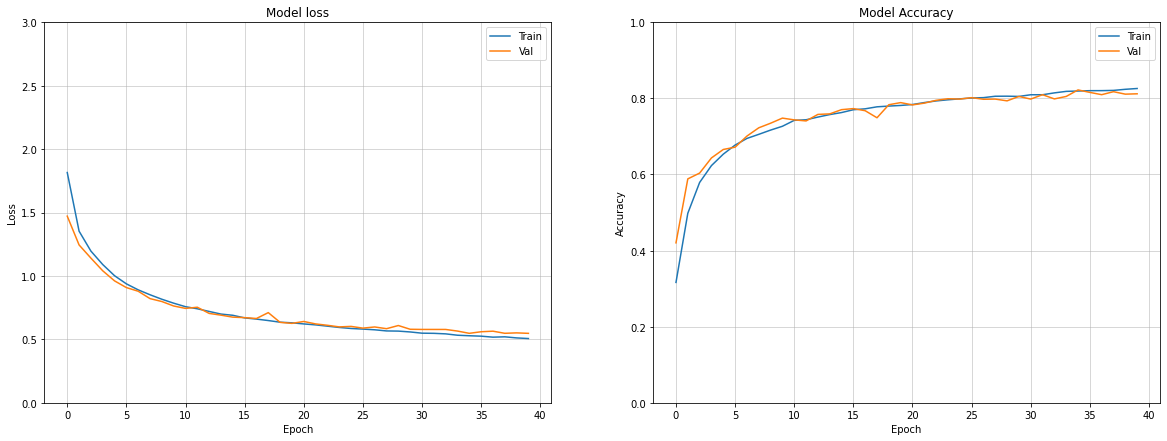

In [30]:
plot_loss_accuracy(history)

## Get metrics and save model

In [36]:
val_accuracy = history.history['val_accuracy'][-1]
test_accuracy = model.evaluate(X_test, y_test)[1]
metrics = dict(accuracy_val = val_accuracy, accuracy_test = test_accuracy)

169/169 [==============================] - 1s 3ms/step - loss: 0.5627 - accuracy: 0.8039


In [37]:
save_model(model, params=params, metrics=metrics)

2022/12/13 11:58:34 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'wfa' already exists. Creating a new version of this model...
2022/12/13 11:58:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wfa, version 7
Created version '7' of model 'wfa'.
